# Object Detection with Transformer

**Object detection** เป็นการตรวจจับวัตถุต่างๆ (คน, สิ่งก่อสร่้าง, รถ) โดยโมเดลจะรับค่ามาเป็นรูปภาพและจะทำนายว่าวัตถุที่เราสนใจนั้นอยู่ตรงส่วนไหนของภาพและวัตถุนั้นจัดอยู่ใน class ใด object detection ถูกใช้ในงานหลากหลายรูปแบบเช่น autonomous driving ที่ใช้โมเดลในการตรวจจับบุคคล, เส้นถนน หรือ สัญญาณไฟ

Tutorial from : https://huggingface.co/docs/transformers/tasks/object_detection

In [ ]:
# install related libraries
!pip install -q datasets transformers evaluate timm albumentations
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.1 MB/s eta 0:00:00


## Import libraries

ที่ใช้ในการทำงาน เราจะใช้ `transformers` และ `datasets` มาช่วยในการทำงาน จาก huggingface hub

In [ ]:
from transformers import AutoModelForObjectDetection # library สำหรับโหลด pre-trained model ที่เราต้องการ
from transformers import AutoImageProcessor # library สำหรับโมเดลที่เป็น image processor
from transformers import TrainingArguments # library สำหรับเก็บ arguments ที่เกี่ยวข้องกับการ train model
from transformers import Trainer # library สำหรับ train model
from datasets import load_dataset # library สำหรับโหลด dataset ที่เราต้องการ
import torch
import torchvision # library สำหรับการทำงานกับรูปภาพ
import evaluate # library สำหรับการคำนวณค่าความแม่นยำของโมเดล
from tqdm import tqdm # library สำหรับการแสดง progress bar
import albumentations # library สำหรับการทำ data augmentation
from PIL import Image, ImageDraw # library สำหรับการทำงานกับรูปภาพ
import requests # library สำหรับการดาวน์โหลดไฟล์จาก Google Drive (และอื่นๆ)
import numpy as np # library สำหรับการทำงานกับ array
import json # library สำหรับการทำงานกับไฟล์ json
import os # library สำหรับการทำงานกับไฟล์และโฟลเดอร์

## Preparing Data

Download `cppe-5` dataset เพื่อใช้ในการ train model และ test model

In [ ]:
cppe5 = load_dataset("cppe-5") # โหลด dataset ที่เราต้องการ
cppe5

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

Dataset cppe-5 downloaded and prepared to /root/.cache/huggingface/datasets/cppe-5/default/1.0.0/dd60c7c8210a67663b06108fb9e23c70acb98e2d3a4f3636f429509b19b74989. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

สร้าง `id2label` และ `label2id` ของ dataset ที่ใช้

In [ ]:
categories = cppe5["train"].features["objects"].feature["category"].names # ดู category ทั้งหมดที่มีใน dataset
id2label = {index: x for index, x in enumerate(categories, start=0)} # สร้าง dictionary ที่ map จาก id ไปยัง label
label2id = {v: k for k, v in id2label.items()} # สร้าง dictionary ที่ map จาก label ไปยัง id

In [ ]:
# remove images with no objects
remove_idx = [590, 821, 822, 875, 876, 878, 879] # ลบรูปภาพที่ไม่มี object ออกจาก dataset
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx] # สร้าง list ของ index ที่เราต้องการเก็บไว้
cppe5["train"] = cppe5["train"].select(keep) # ลบรูปภาพที่ไม่มี object ออกจาก dataset 

## Transform Data

`trasnfrom` data ก่อนที่จะเข้าไปใช้ใน model โดยใช้ `albumentations` ในการทำ data augmentation

In [ ]:
# สร้างขั้นตอนการแปลงรูปภาพเป็น feature vector โดยมีขั้นตอนดังนี้
# 1. ทำการ resize รูปภาพให้มีขนาด 480x480
# 2. ทำการกลับภาพแนวนอน (horizontal flip)
# 3. ทำการแปลง random brightness () และ contrast 
# โดยที่ p คือความน่าจะเป็นที่จะทำการแปลง
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480), # resize to 480x480
        albumentations.HorizontalFlip(p=1.0), # horizontal flip
        albumentations.RandomBrightnessContrast(p=1.0), # random brightness and contrast 
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]), # กำหนด format ของ bounding box และ label
)

define function สำหรับการ train model

In [ ]:
# formatted annotations
# ในการทำ annotation จะมี format ได้หลายรูปแบบโดยในที่นี้จะเป็น coco format
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt") # ปรับขนาดของรูปภาพให้เหมาะสมกับโมเดล
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [ ]:
# train from cppe5 model with augmentation
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)

## Create and Train a Model

In [ ]:
# เลือก pretrain_model และ image processor ที่จะใช้
checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
# สร้าง model จาก pretrain_model ที่เลือก
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


กำหนด `training_args` และ `trainer` สำหรับการเทรนโมเดล

In [ ]:
# [optional] disable wandb ที่ใช้ในการ log ข้อมูล
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
training_args = TrainingArguments(
    output_dir="{directory_name}", # ชื่อโฟลเดอร์ที่เราจะเก็บ model ที่ train ได้
    per_device_train_batch_size=2, # จำนวน batch size
    num_train_epochs=10,  # จำนวน epoch ที่เราต้องการให้โมเดล train
    fp16=False, # ใช้ mixed precision หรือไม่
    save_steps=200, # จำนวน step ที่เราต้องการให้โมเดล save
    logging_steps=50,
    learning_rate=1e-5, # ค่า learning rate
    weight_decay=1e-4, # ค่า weight decay
    save_total_limit=2, # จำนวน model ที่เราต้องการให้โมเดล save
    remove_unused_columns=False,
    push_to_hub=False,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# สร้าง trainer จาก model ที่เราสร้างไว้
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

In [ ]:
trainer.train() # train model

Step,Training Loss
50,2.076000
100,2.132500
150,1.933300
200,2.010700
250,1.989500
300,1.859800
350,2.015400
400,1.929600
450,1.872200
500,2.067200


TrainOutput(global_step=4970, training_loss=1.5700076181883784, metrics={'train_runtime': 3326.617, 'train_samples_per_second': 2.985, 'train_steps_per_second': 1.494, 'total_flos': 4.7455894400256e+18, 'train_loss': 1.5700076181883784, 'epoch': 10.0})

## Evaluate the Trained Model

ทดสอบ model หรือ `evaluation` เพื่อเช็คผลลัพธ์ของโมเดล

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/cppe5/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
        path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
        im.save(path_img)

    return path_output_cppe5, path_anno

เลือก `model` /`checkpoint` ที่เราใช้ในการ evaluate

In [ ]:
model_path = "{directory_name}/checkpoint-4800" # ใส่ directory ของ model ที่เราเทรนไว้

In [ ]:
# เลือก processor จาก model ที่เรา train ไว้
im_processor = AutoImageProcessor.from_pretrained(f"{model_path}/preprocessor_config.json", local_files_only=True)
path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

# เลือก model ที่เรา train ไว้
model = AutoModelForObjectDetection.from_pretrained(f"{model_path}", local_files_only=True)
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn
)

# prediction และ evaluation
with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()

# แสดงผล evaluation
print(results)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 15/15 [03:10<00:00, 12.67s/it]


Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

## Test the Model

In [ ]:
# เลือกรูปที่ต้องการ predict จาก url
url = "https://media.istockphoto.com/id/1221713778/photo/doctor-working-at-the-hospital-wearing-a-facemask-to-avoid-covid-19.jpg?s=612x612&w=0&k=20&c=EYJ7Kt9RtHLGqE6Fh8SY27D-mN3X--plXIvTgASABw0="
image = Image.open(requests.get(url, stream=True).raw)

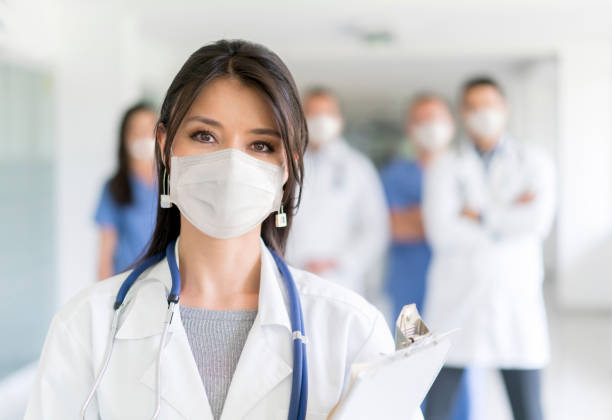

In [ ]:
display(image)

In [ ]:
model_path = "{directory_name}/checkpoint-4800" # ใส่ directory ของ model ที่เราเทรนไว้

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(f"{model_path}/preprocessor_config.json", local_files_only=True)  # processor
model = AutoModelForObjectDetection.from_pretrained(f"{model_path}", local_files_only=True) # model

# predict image
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0] # ใส่ threshold ที่เหมาะสม

`thesold` เราสามารถเปลี่ยนค่าได้ตามความเหมาะสม เนื่องจากในบาง model ที่เราเทรนไว้ จะมีค่า confidence ของการ `prediction` ที่ต่างกัน

In [ ]:
# visualize results
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Mask with confidence 0.53 at location [302.52, 104.34, 347.88, 150.15]
Detected Mask with confidence 0.555 at location [406.68, 113.05, 453.15, 154.7]
Detected Mask with confidence 0.512 at location [459.08, 101.26, 505.28, 149.77]
Detected Mask with confidence 0.507 at location [454.49, 90.49, 507.94, 152.42]
Detected Mask with confidence 0.613 at location [168.46, 148.81, 288.17, 237.72]
Detected Coverall with confidence 0.892 at location [27.68, 37.03, 392.3, 418.04]
Detected Gloves with confidence 0.635 at location [390.18, 300.32, 433.65, 347.41]
Detected Coverall with confidence 0.777 at location [399.29, 68.52, 550.06, 416.53]


Visualize prediction โดยใช้ `ImageDraw`

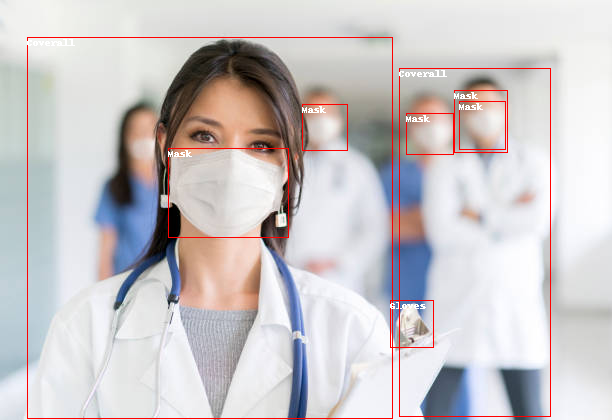

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

**ผู้จัดเตรียม code ใน tutorial**: ดร. ฐิติพัทธ อัชชะกุลวิสุทธิ์